In [1]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib
import matplotlib.pyplot as plt

### Functions for model

In [2]:
# Dataset and Transformations
class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        img = T.Resize((self.size, self.size))(img)
        return img, target

class RoboflowDataset(Dataset):
    def __init__(self, root, folder='train', transforms=None):
        self.root = root
        self.transforms = transforms
        self.folder = folder
        if not folder in ['test', 'train', 'valid']:
            print("Invalid folder parameter. Must be 'valid', 'test' or 'train'. Using default train folder.") 
            self.folder = "train"
            
        self.imgs = sorted(os.listdir(os.path.join(root, f"{self.folder}/images")))
        self.annotations = sorted(os.listdir(os.path.join(root, f"{self.folder}/labels")))

        # Filter images with valid annotations
        self.data = []
        for img, ann in zip(self.imgs, self.annotations):
            ann_path = os.path.join(root, f"{self.folder}/labels", ann)
            if os.path.exists(ann_path):
                with open(ann_path, 'r') as f:
                    lines = f.readlines()
                if len(lines) > 0:  # Check if there are any annotations
                    self.data.append((img, ann))

        self.to_tensor = T.ToTensor()

    def __getitem__(self, idx):
        img_name, ann_name = self.data[idx]
        img_path = os.path.join(self.root, f"{self.folder}/images", img_name)
        ann_path = os.path.join(self.root, f"{self.folder}/labels", ann_name)

        img = Image.open(img_path).convert("RGB")
        img = self.to_tensor(img)

        # Parse YOLO annotations
        with open(ann_path, 'r') as f:
            lines = f.readlines()

        boxes = []
        labels = []
        for line in lines:
            label, x_center, y_center, width, height = map(float, line.strip().split())
            xmin = (x_center - width / 2) * img.shape[2]
            xmax = (x_center + width / 2) * img.shape[2]
            ymin = (y_center - height / 2) * img.shape[1]
            ymax = (y_center + height / 2) * img.shape[1]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(label))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Exclude entries with no boxes
        if boxes.numel() == 0:
            raise ValueError(f"Empty boxes for image {img_name}")

        target = {"boxes": boxes, "labels": labels}
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data)

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### Plot mAP graph

In [9]:
import csv

def read_rcnn_csv(path):
    # Initialize lists to store the mAP values and epochs
    epochs = []
    train_map_50 = []
    train_map_50_95 = []
    test_map_50 = []
    test_map_50_95 = []

    # Read the CSV file and extract the data
    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            epochs.append(int(row[0]))
            train_map_50.append(float(row[4]))
            train_map_50_95.append(float(row[5]))
            test_map_50.append(float(row[6]))
            test_map_50_95.append(float(row[7]))
    
    return epochs, train_map_50, train_map_50_95, test_map_50, test_map_50_95

def read_yolo_csv(path):
    dd = {}
    headers = []
    with open(path, newline="") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if dd == {}:
                for i in range(len(row)):
                    dd[row[i]] = [] 
                    headers.append(row[i])
            else:
                for i in range(len(row)):
                    dd[headers[i]].append(row[i])
    return dd


data_dict = read_yolo_csv("yolov8s_training_stats.csv")

print(data_dict.keys())

dict_keys(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'])


100 100


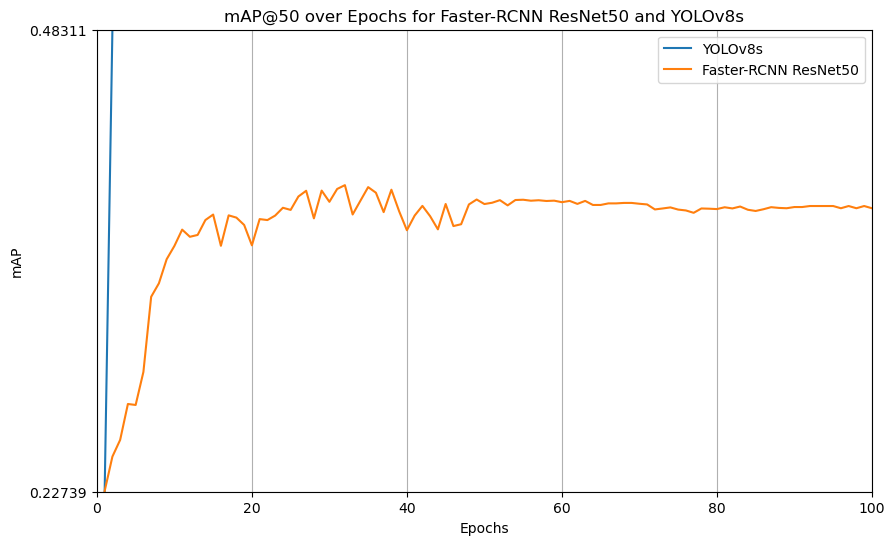

In [37]:
import matplotlib.pyplot as plt

# Define the CSV file path
rcnn_file = 'rcnn_training_stats.csv'
yolo_file = 'yolov8s_training_stats.csv'

epochs, train_map_50, train_map_50_95, test_map_50, test_map_50_95 = read_rcnn_csv(rcnn_file)
yolo_data = read_yolo_csv(yolo_file)

# Plotting the mAP values over epochs
plt.figure(figsize=(10, 6))

print(len(yolo_data["metrics/mAP50(B)"]), len(epochs))

# Plot test set mAP@50
plt.plot(epochs, yolo_data["metrics/mAP50(B)"], label="YOLOv8s")
plt.plot(epochs, test_map_50, label="Faster-RCNN ResNet50") # fasterrcnn_resnet50_fpn

# Plot mAP@50 and mAP@50-95 for Train and Test sets
# plt.plot(epochs, train_map_50, label="Train mAP@50", marker='o')
# plt.plot(epochs, train_map_50_95, label="Train mAP@50-95", marker='o')
# plt.plot(epochs, test_map_50, label="Test mAP@50", marker='x')
# plt.plot(epochs, test_map_50_95, label="Test mAP@50-95", marker='x')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("mAP@50 over Epochs for Faster-RCNN ResNet50 and YOLOv8s")
plt.legend(loc="best")
plt.grid(True)

plt.ylim(0,1)
plt.xlim(0, max(epochs))

# Show the plot
plt.show()

### Visualisation Functions

In [6]:
import random

def visualize_image_with_boxes(img, boxes, scores, labels):
    """
    Visualize a single image with bounding boxes.
    :param img: Image as a NumPy array (HWC)
    :param boxes: Bounding boxes as a NumPy array [[xmin, ymin, xmax, ymax], ...]
    :param scores: Confidence scores as a NumPy array
    :param labels: Labels as a NumPy array
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        # Create a rectangle patch
        rect = matplotlib.patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add label and score
        label = f"{labels[i]}: {scores[i]:.2f}"
        ax.text(xmin, ymin - 10, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

def visualize_predictions_randomized(model, dataset, device, num_images=5, threshold=0.5):
    """
    Visualize predictions on randomly selected test images.
    :param model: Trained Faster R-CNN model
    :param dataset: The test dataset (not DataLoader, so we can randomly index)
    :param device: Torch device (CPU or CUDA)
    :param num_images: Number of test images to visualize
    :param threshold: Confidence threshold for predictions
    """
    model.eval()  # Set model to evaluation mode

    # Select random indices
    random_indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in random_indices:
            img, target = dataset[idx]
            img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension

            # Perform inference
            output = model(img_tensor)[0]

            # Convert tensors to numpy for visualization
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert image to HWC
            img_np = (img_np * 255).astype('uint8')  # Scale to [0, 255]

            # Extract predictions above the confidence threshold
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            high_conf_idx = scores > threshold
            boxes = boxes[high_conf_idx]
            scores = scores[high_conf_idx]
            labels = labels[high_conf_idx]

            # Visualize the image and predictions
            visualize_image_with_boxes(img_np, boxes, scores, labels)


/home/s14-htx/anaconda3/envs/roadsigns/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s14-htx/anaconda3/envs/roadsigns/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


42


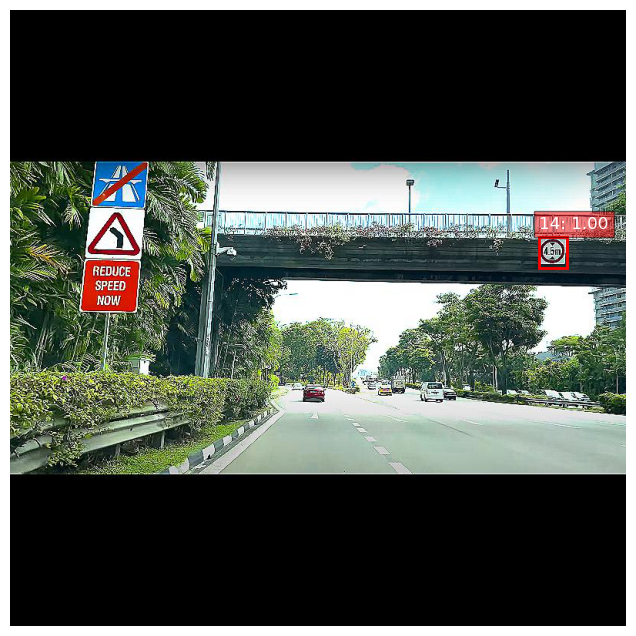

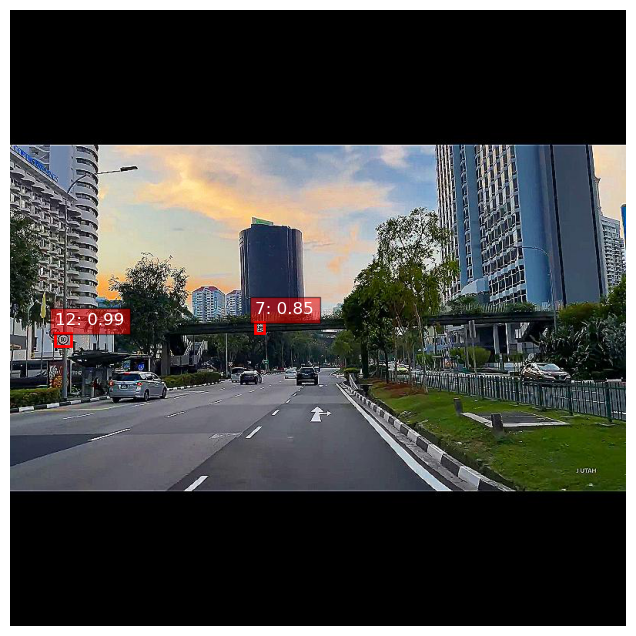

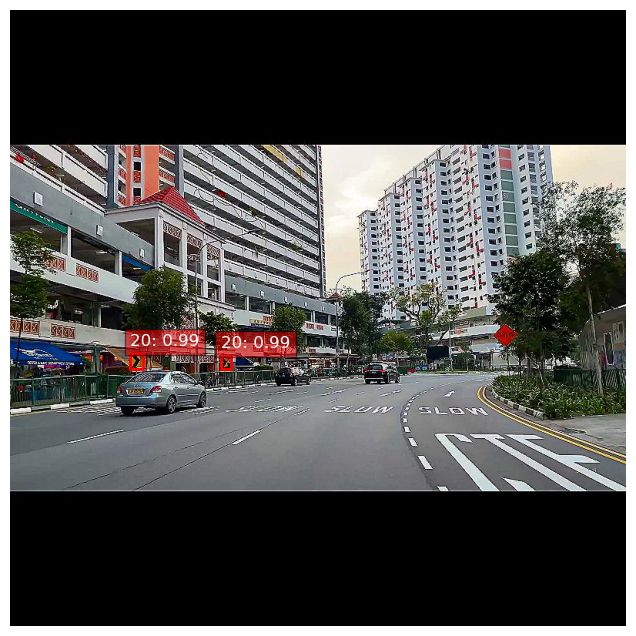

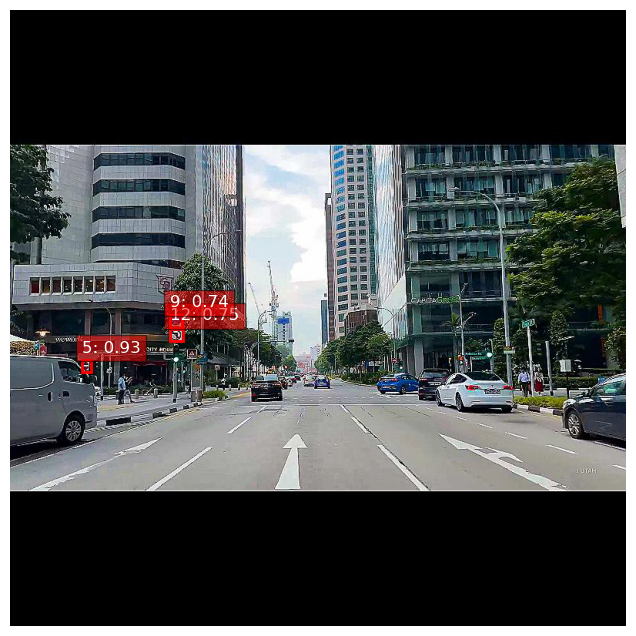

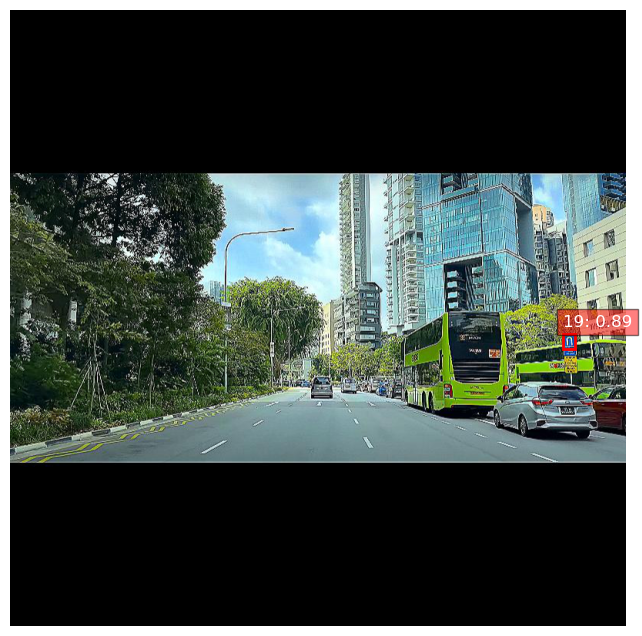

In [7]:
# Visualize random predictions from the test dataset
model = get_model(num_classes=22)
model.load_state_dict(torch.load("/home/s14-htx/Documents/GitHub/GPU_file_sharing/RCNN_100_16.pth", weights_only=True))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Params
img_size = 800

# Dataset and DataLoader for the test set
dataset_path = "SG-Road-Signs-2"
transforms = ResizeTransform(img_size)
test_dataset = RoboflowDataset(dataset_path, folder='test', transforms=transforms)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(len(test_dataset))

visualize_predictions_randomized(model, test_dataset, device, num_images=5, threshold=0.5)

In [8]:
# Run YOLO prediction

